In [44]:
import re
from scipy.stats import chisquare
from itertools import combinations
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean, braycurtis
import numpy as np

%cd /work/site_rate/hug_et_al/

/work/site_rate/hug_et_al


In [70]:
import matplotlib.colors

cmap = plt.cm.RdBu_r
norm = matplotlib.colors.Normalize(vmin=-1, vmax=12)
colors = ['#%02x%02x%02x' % cmap(norm(index), bytes=8)[:3]
          for index in range(0,13)]

In [45]:
lg_frequencies  = np.asarray(
                      [0.079066, 0.055941, 0.041977, 0.053052,
                       0.012937, 0.040767, 0.071586, 0.057337,
                       0.022355, 0.062157, 0.099081, 0.064600,
                       0.022951, 0.042302, 0.044040, 0.061197,
                       0.053287, 0.012066, 0.034155, 0.069147])
lg_aa_order     =     'A         R         N         D\
                       C         Q         E         G\
                       H         I         L         K\
                       M         F         P         S\
                       T         W         Y         V'.split()

In [109]:
%cd /work/site_rate/hug_et_al/
fasta = open('ribosomal_concat.fasta').read()
fasta_no_header = '\n'.join(re.findall('^([^>]\S+)$', fasta, re.M))

aa_count             = []
observed_frequencies = []
for aa in lg_aa_order:
    aa_count.append(fasta_no_header.count(aa))

for aa in aa_count:
    observed_frequencies.append(aa/sum(aa_count))
observed_frequencies = np.asarray(observed_frequencies)

/work/site_rate/hug_et_al


In [110]:
sum((observed_frequencies - lg_frequencies)**2)

0.006182872703390046

In [37]:
categories_aa_frequencies = {}
categories_aa_count       = {}
for category in range(1,13):
    fasta = open('categories/%i.aln' % category).read()
    fasta_no_header = '\n'.join(re.findall('^([^>]\S+)$', fasta, re.M))
    
    cat_aa_count             = []
    cat_observed_frequencies = []
    for aa in lg_aa_order:
        cat_aa_count.append(fasta_no_header.count(aa))

    for aa in cat_aa_count:
        cat_observed_frequencies.append(aa/sum(cat_aa_count))
    
    categories_aa_count[      category] = cat_aa_count
    categories_aa_frequencies[category] = np.asarray(cat_observed_frequencies)

[Text(0, 0, '0.0233'),
 Text(0, 0, '0.0897'),
 Text(0, 0, '0.1752'),
 Text(0, 0, '0.2782'),
 Text(0, 0, '0.4004'),
 Text(0, 0, '0.5458'),
 Text(0, 0, '0.721'),
 Text(0, 0, '0.9372'),
 Text(0, 0, '1.2147'),
 Text(0, 0, '1.5957'),
 Text(0, 0, '2.1944'),
 Text(0, 0, '3.8243')]

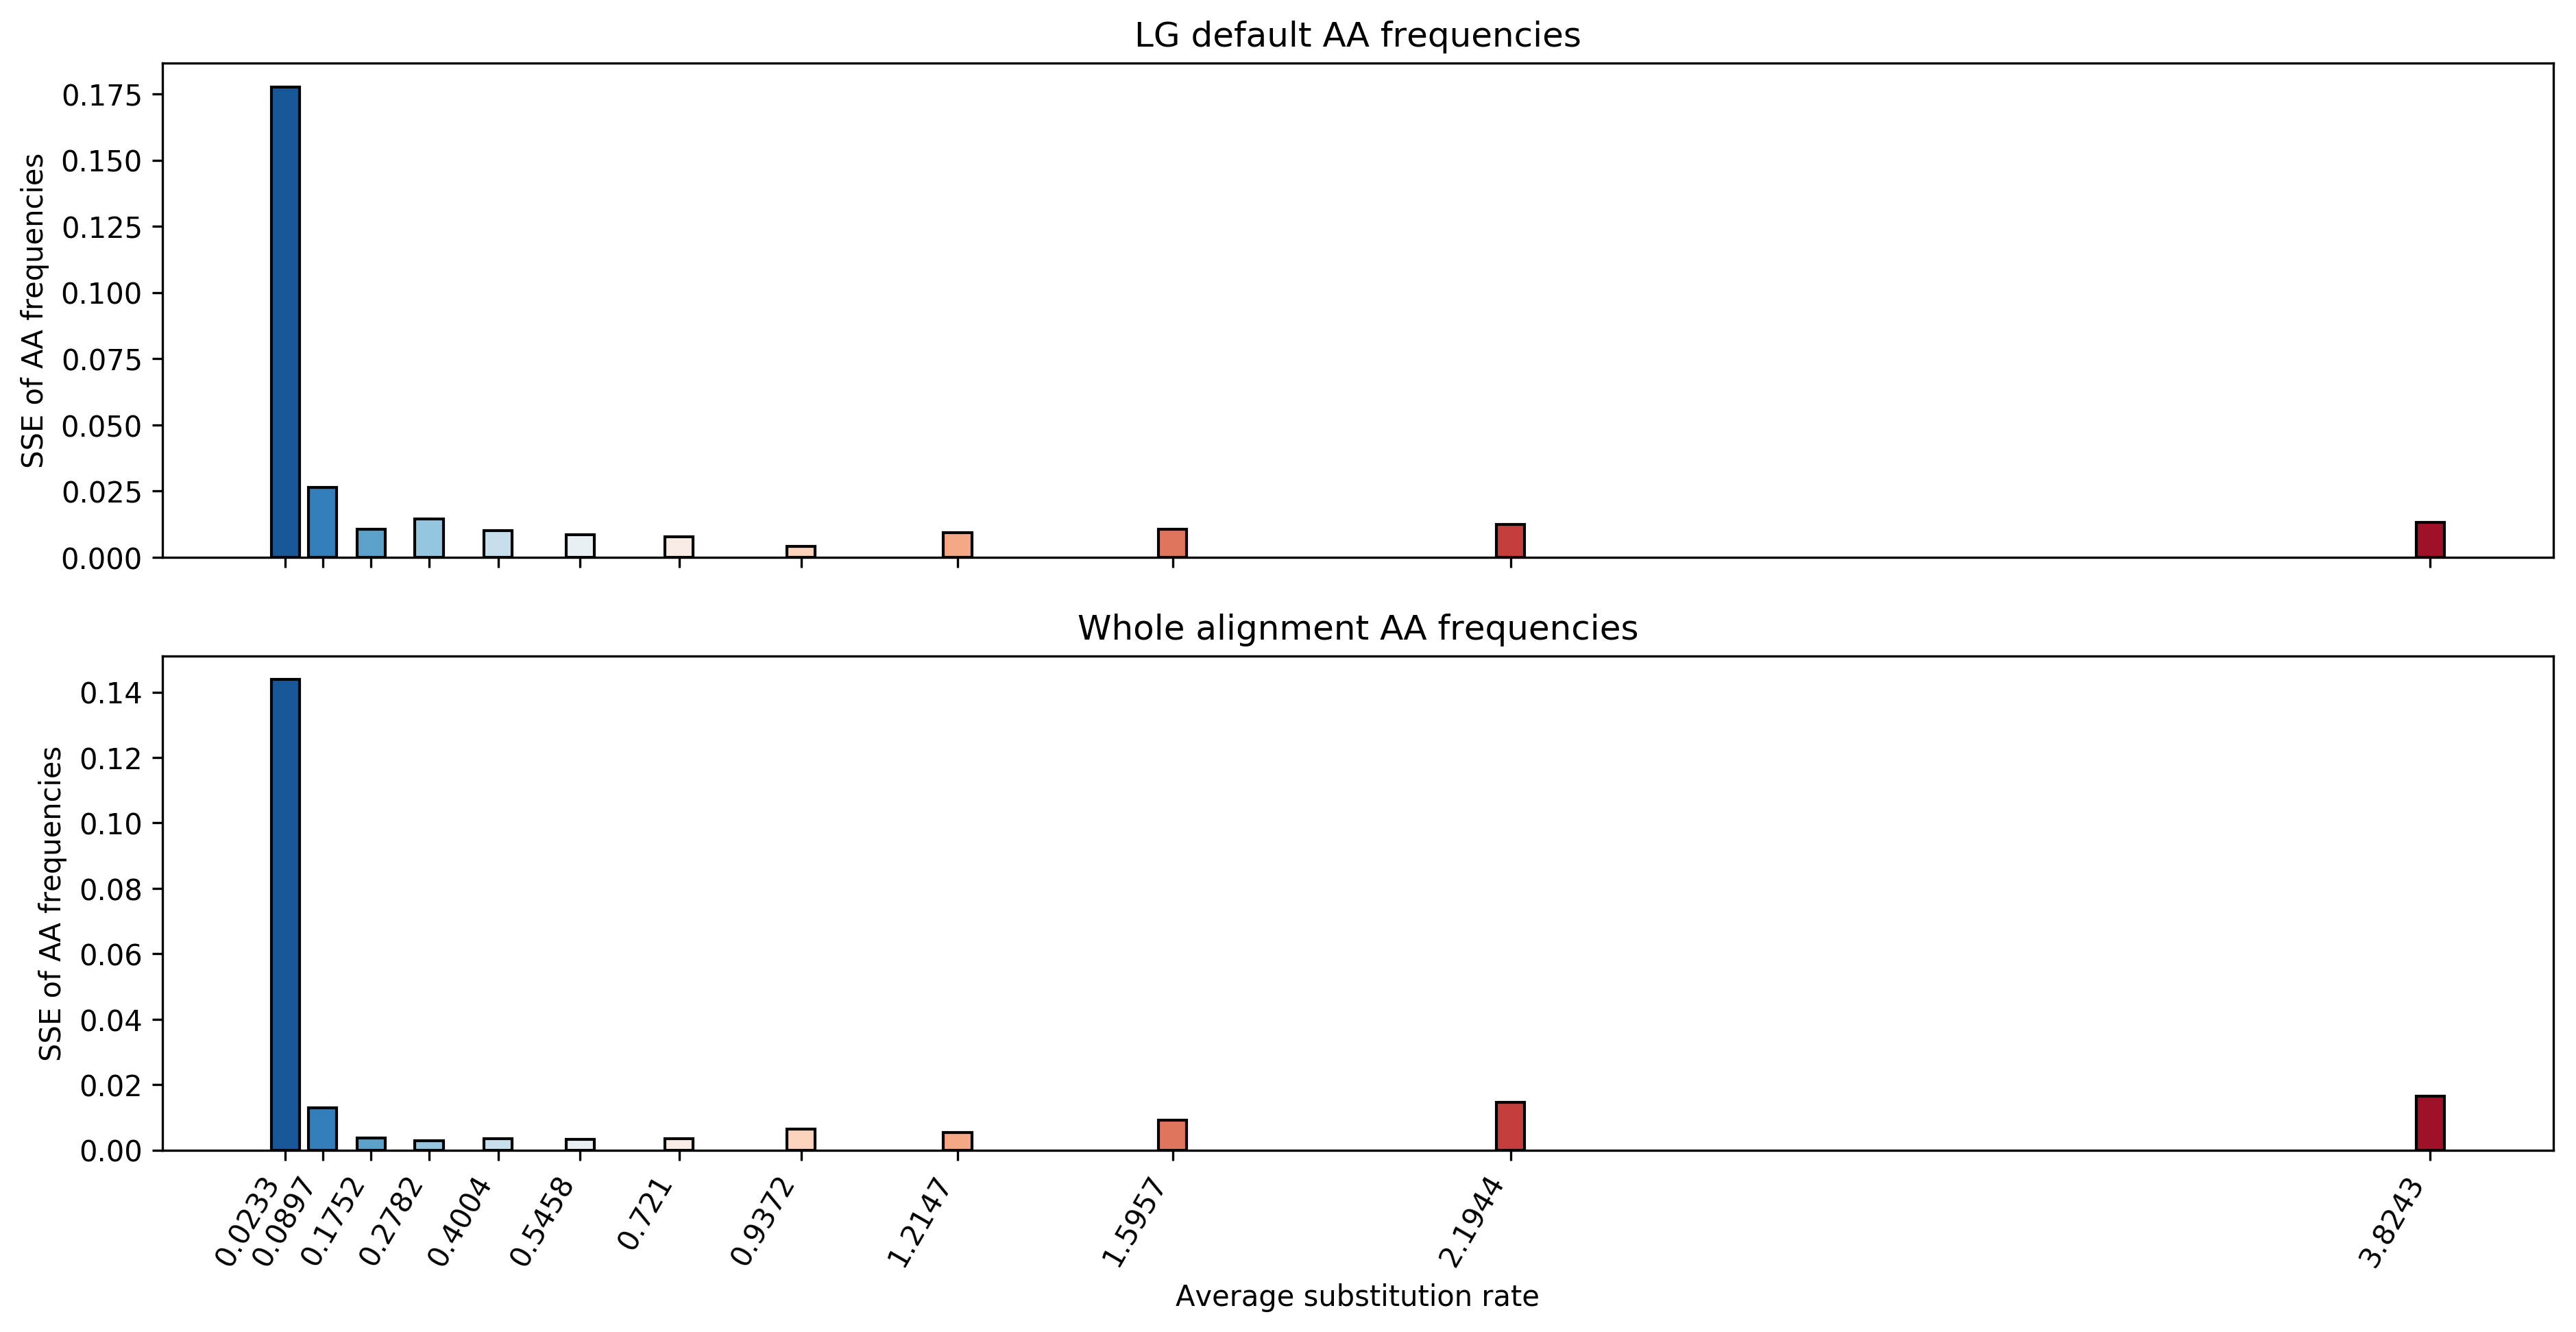

In [78]:
lg_squared_errors = []
for category in range(1,13):
    lg_squared_errors.append(
        sum((categories_aa_frequencies[category] - lg_frequencies)**2)
    )

alignment_squared_errors = []
for category in range(1,13):
    alignment_squared_errors.append(
        sum((categories_aa_frequencies[category] - observed_frequencies)**2)
    )
    
fig, axs = plt.subplots(dpi=300, figsize=(15,7), nrows=2, sharex=True)
axs[0].bar([0.02332, 0.08971, 0.17524, 0.27821, 0.40042, 
            0.5458, 0.721, 0.93721, 1.21474, 1.59572, 2.19435, 3.82427],
           lg_squared_errors, width=0.05, color=colors, edgecolor='k')
axs[0].set_title('LG default AA frequencies')
axs[0].set_ylabel('SSE of AA frequencies')

axs[1].bar([0.02332, 0.08971, 0.17524, 0.27821, 0.40042, 
            0.5458, 0.721, 0.93721, 1.21474, 1.59572, 2.19435, 3.82427],
           alignment_squared_errors, width=0.05, color=colors, edgecolor='k')
axs[1].set_title('Whole alignment AA frequencies')
axs[1].set_ylabel('SSE of AA frequencies')
axs[1].set_xlabel('Average substitution rate')

axs[1].set_xticks([0.02332, 0.08971, 0.17524, 0.27821, 0.40042, 
                   0.5458, 0.721, 0.93721, 1.21474, 1.59572, 2.19435, 3.82427])
axs[1].set_xticklabels([round(n, 4) for n in
                        [0.02332, 0.08971, 0.17524, 0.27821, 0.40042, 
                         0.5458, 0.721, 0.93721, 1.21474, 1.59572, 2.19435, 3.82427]],
                       rotation=60, ha='right')

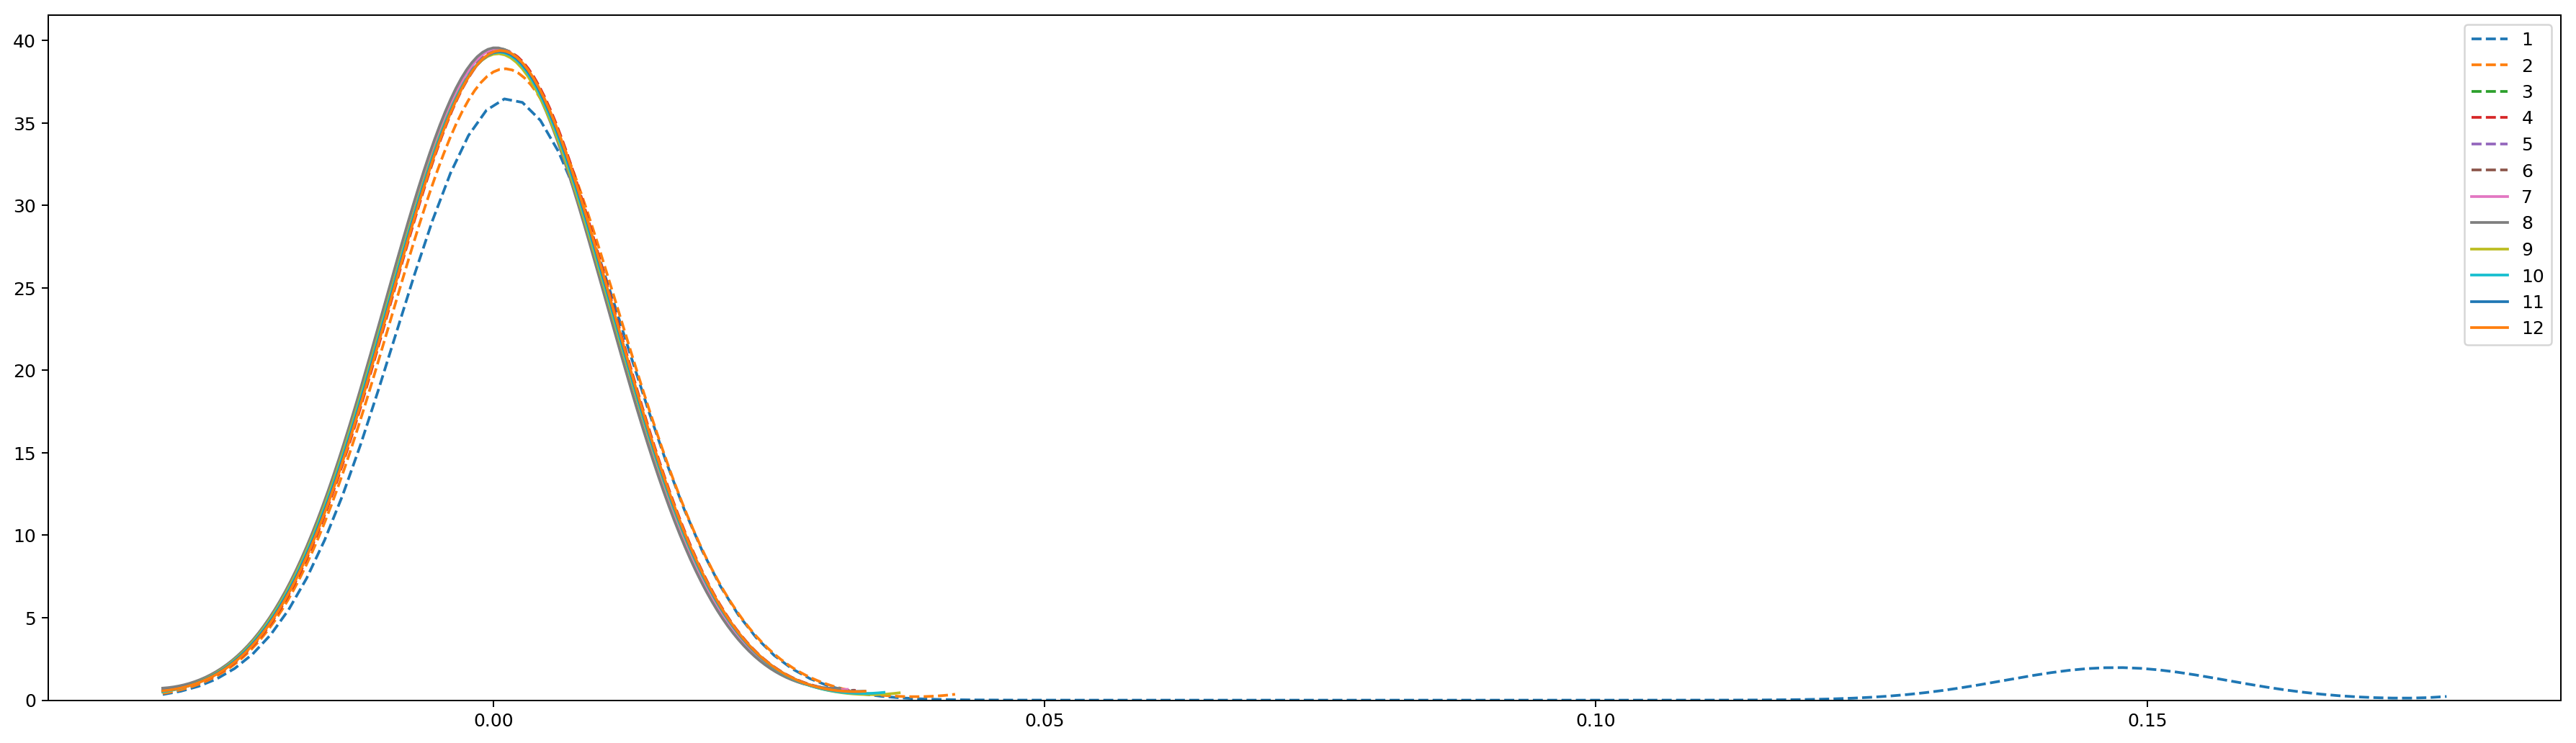

In [87]:
fig, ax = plt.subplots(dpi=180, figsize=(25,7))
for i,j in enumerate([(categories_aa_frequencies[category] - lg_frequencies)**2
                      for category in range(1,13)], 1):
    if i > 6:
        linestyle = '-'
    else:
        linestyle = '--'
    sns.kdeplot(j, shade=False, label=i, ax=ax, bw=0.01, linestyle=linestyle)

In [102]:
%cd /work/site_rate/sequence_simulation/hug/
sim_fasta = open('2.fas').read()
sim_fasta_no_header = '\n'.join(re.findall('^([^>]\S+\s+)$', sim_fasta, re.M))

sim_aa_count             = []
sim_observed_frequencies = []
for aa in lg_aa_order:
    sim_aa_count.append(sim_fasta_no_header.count(aa))

for aa in sim_aa_count:
    sim_observed_frequencies.append(aa/sum(sim_aa_count))
sim_observed_frequencies = np.asarray(sim_observed_frequencies)

/work/site_rate/sequence_simulation/hug


In [104]:
sim_categories_aa_frequencies = {}
sim_categories_aa_count       = {}
for category in range(1,13):
    sim_fasta = open('categories/2.%i.aln' % category).read()
    sim_fasta_no_header = '\n'.join(re.findall('^([^>]\S+)$', sim_fasta, re.M))
    
    sim_cat_aa_count             = []
    sim_cat_observed_frequencies = []
    for aa in lg_aa_order:
        sim_cat_aa_count.append(sim_fasta_no_header.count(aa))

    for aa in sim_cat_aa_count:
        sim_cat_observed_frequencies.append(aa/sum(sim_cat_aa_count))
    
    sim_categories_aa_count[      category] = sim_cat_aa_count
    sim_categories_aa_frequencies[category] = np.asarray(sim_cat_observed_frequencies)

[Text(0, 0, '0.0233'),
 Text(0, 0, '0.0897'),
 Text(0, 0, '0.1752'),
 Text(0, 0, '0.2782'),
 Text(0, 0, '0.4004'),
 Text(0, 0, '0.5458'),
 Text(0, 0, '0.721'),
 Text(0, 0, '0.9372'),
 Text(0, 0, '1.2147'),
 Text(0, 0, '1.5957'),
 Text(0, 0, '2.1944'),
 Text(0, 0, '3.8243')]

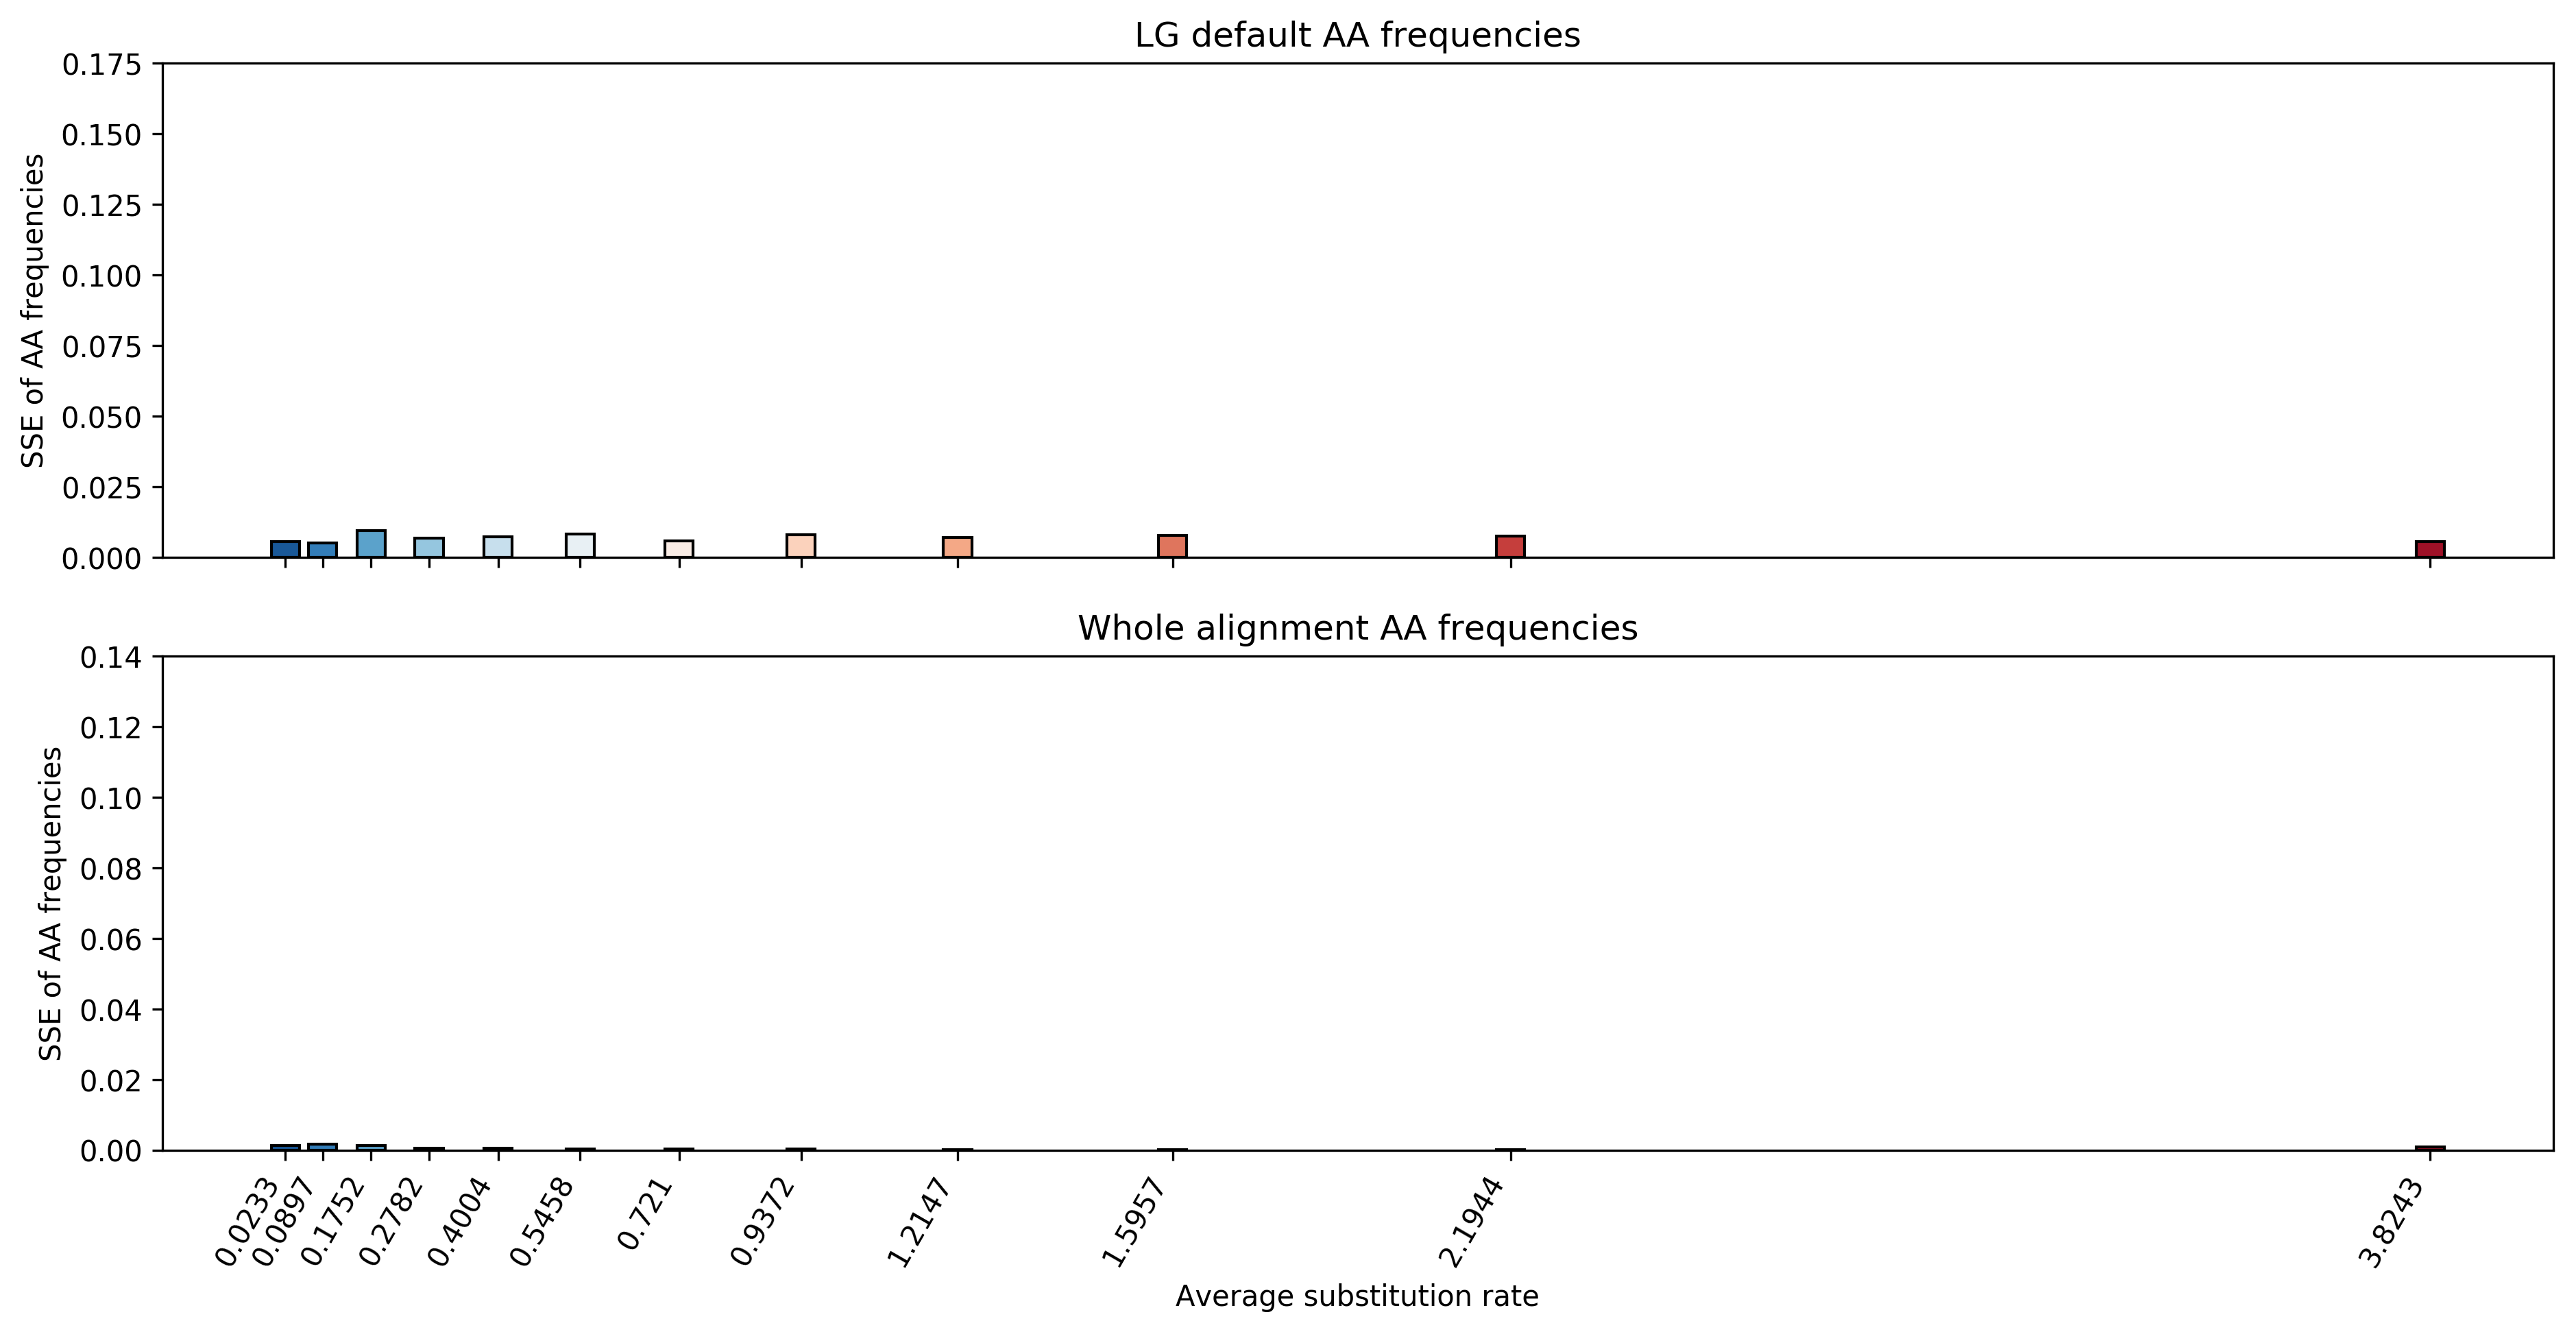

In [112]:
sim_lg_squared_errors = []
for category in range(1,13):
    sim_lg_squared_errors.append(
        sum((sim_categories_aa_frequencies[category] - lg_frequencies)**2)
    )

sim_alignment_squared_errors = []
for category in range(1,13):
    sim_alignment_squared_errors.append(
        sum((sim_categories_aa_frequencies[category] - sim_observed_frequencies)**2)
    )
    
fig, axs = plt.subplots(dpi=300, figsize=(15,7), nrows=2, sharex=True)
axs[0].bar([0.02332, 0.08971, 0.17524, 0.27821, 0.40042, 
            0.5458, 0.721, 0.93721, 1.21474, 1.59572, 2.19435, 3.82427],
           sim_lg_squared_errors, width=0.05, color=colors, edgecolor='k')
axs[0].set_title('LG default AA frequencies')
axs[0].set_ylabel('SSE of AA frequencies')
axs[0].set_ylim(0,0.175)

axs[1].bar([0.02332, 0.08971, 0.17524, 0.27821, 0.40042, 
            0.5458, 0.721, 0.93721, 1.21474, 1.59572, 2.19435, 3.82427],
           sim_alignment_squared_errors, width=0.05, color=colors, edgecolor='k')
axs[1].set_title('Whole alignment AA frequencies')
axs[1].set_ylabel('SSE of AA frequencies')
axs[1].set_xlabel('Average substitution rate')
axs[1].set_ylim(0,0.14)

axs[1].set_xticks([0.02332, 0.08971, 0.17524, 0.27821, 0.40042, 
                   0.5458, 0.721, 0.93721, 1.21474, 1.59572, 2.19435, 3.82427])
axs[1].set_xticklabels([round(n, 4) for n in
                        [0.02332, 0.08971, 0.17524, 0.27821, 0.40042, 
                         0.5458, 0.721, 0.93721, 1.21474, 1.59572, 2.19435, 3.82427]],
                       rotation=60, ha='right')